# 10. Use vision model to read the figure

This notebook demonstrates how vision model can read and summarize scientific figure from the simulation output.

In [1]:
import os
from pprint import pprint

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain.chains.transform import TransformChain
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain import globals
from langchain_core.runnables import chain
from langchain_core.output_parsers import JsonOutputParser
from matplotlib import pyplot as plt

import base64

load_dotenv()

MP_API_KEY = os.getenv("MP_API_KEY", None)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", None)
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION", None)


OPENAI_GPT_MODEL = "gpt-4-1106-preview"
# OPENAI_GPT_MODEL = "gpt-4-0125-preview"
# OPENAI_GPT_MODEL = "gpt-3.5-turbo-1106"
# OPENAI_GPT_MODEL = "gpt-4-turbo"

## Define image encoding function and output schema

In [2]:

def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
  
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}


class ImageInformation(BaseModel):
    """Information and description about a figure."""
    title: str = Field(description="title of the figure")
    xlabel: str = Field(description="label of the x-axis")
    ylabel: str = Field(description="label of the y-axis")
    xrange: list[float] = Field(description="range of the x-axis")
    yrange: list[float] = Field(description="range of the y-axis")
    description: str = Field(description="description of the meaning of the figure, the data and the context")

## Define LLM chain to process figure

In [3]:
load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)


# Set verbose
globals.set_debug(True)

parser = JsonOutputParser(pydantic_object=ImageInformation)

@chain
def image_model(inputs: dict) -> str | list[str] | dict:
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)
 msg = model.invoke(
   [HumanMessage(
      content=[
         {"type": "text", "text": inputs["prompt"]},
         {"type": "text", "text": parser.get_format_instructions()},
         {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
   ])]
   )
 return msg.content

def read_figure(image_path: str) -> dict:
   vision_prompt = """
   Given the image, provide the following information:
   - Title of the figure
   - Type of the figure (e.g., bar chart, line chart, scatter plot)
   - Labels and ranges of the axes
   - Legend, including the meaning of the colors, names, and symbols
   - A brief description of the data and trends
   """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "Ag-eos.png",
  "prompt": "\n   Given the image, provide the following information:\n   - Title of the figure\n   - Type of the figure (e.g., bar chart, line chart, scatter plot)\n   - Labels and ranges of the axes\n   - Legend, including the meaning of the colors, names, and symbols\n   - A brief description of the data and trends\n   "
}
[chain/start] [chain:RunnableSequence > chain:TransformChain] Entering Chain run with input:
{
  "image_path": "Ag-eos.png",
  "prompt": "\n   Given the image, provide the following information:\n   - Title of the figure\n   - Type of the figure (e.g., bar chart, line chart, scatter plot)\n   - Labels and ranges of the axes\n   - Legend, including the meaning of the colors, names, and symbols\n   - A brief description of the data and trends\n   "
}
[chain/end] [chain:RunnableSequence > chain:TransformChain] s] Exiting Chain run with output:
{
  "image": "iVBORw0KG
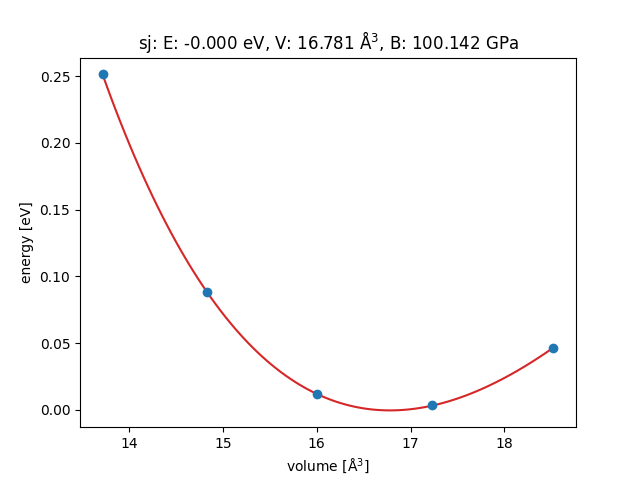

In [4]:
result = read_figure("Ag-eos.png")

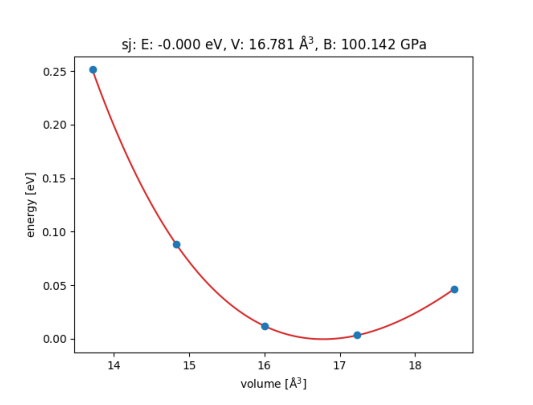

{'description': 'The figure appears to be a scatter plot with a fitted curve, '
                'representing the relationship between energy and volume. The '
                'plot shows discrete data points that are connected by a '
                'smooth curve, suggesting a trend where energy decreases as '
                'volume increases, up to a certain point, after which the '
                'energy starts to increase with increasing volume. This is '
                'indicative of a typical energy-volume relationship for a '
                'material, where there is an optimal volume that minimizes the '
                'energy. The annotations at the top left indicate the minimum '
                'energy (E: -0.000 eV), the corresponding volume (V: 16.781 '
                'Å³), and the bulk modulus (B: 100.142 GPa).',
 'title': 'Energy vs. Volume',
 'xlabel': 'volume [Å³]',
 'xrange': [14, 18],
 'ylabel': 'energy [eV]',
 'yrange': [0.0, 0.25]}


In [5]:

with plt.style.context("default"):

    plt.figure(figsize=(10, 5))
    plt.imshow(plt.imread("Ag-eos.png"))
    plt.axis("off")
    plt.show()

pprint(result)
